<a href="https://colab.research.google.com/github/pgordin/OptDisc2025/blob/main/Grafy6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algorytmy optymalizacji dyskretnej; laboratoria
Ten notatnik zawiera implementację klas *Graph* i *WeightedGraph*, przedstawiąjących podstawowe funkcje grafowe prezentowane na zajęciach.

Import pakietów.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy

## Podstawowe funkcje z pierwszych zajęć
Pozostawione tylko jako przykład (w celu porównania zachowania).

In [2]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

## Klasa *Graph*

In [3]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle

    def draw(self):
      """
      Draws the graph using networkx.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def connected_components(self):
      """
      Szuka spójnych skłądowych w (nieskierowanym) grafie.
      Zwraca listę zbiorów wierzchołków.
      Uwaga: zerowy element listy zawiera wszystkie wierzchołki grafu
      """
      def DFS(u):
        """
        Przechodzenie w głąb - metoda wewnętrzna
        """
        for w in self.graph[u]:
          if w not in VT[0]:    # w jeszcze nieodwiedzony
            VT[0].add(w)        # już odwiedzony
            VT[-1].add(w)       # w ostatniej (aktualnej) spójnej składowej
            DFS(w)
      """
      VT - lista zbiorów wierzchołków (drzew DFS).
      VT[0] - docelowo lista wszystkich wierzchołków w grafie.
      """
      VT = [set([])]
      for v in self.graph:
        if not v in VT[0]:  # v - nieodwiedzony
          VT[0].add(v)      # już odwiedzony
          VT.append(set([v])) # zalążek nowej spójnej składowej
          DFS(v)
      return VT

    def connected_components_graphs(self):
      """
      Zwraca listę spójnych składowych (jako grafów).
      """
      components = self.connected_components()  # lista zbiorów wierzchołków
      component_graphs = []                     # zalążek listy grafów
      for component in components[1:]:
        subgraph = Graph()
        for vertex in component:
          subgraph.graph[vertex] = self.graph[vertex].copy()
        component_graphs.append(subgraph)
      return component_graphs

    def distance(self, v):
      """
      Oblicza odległości z wierzhołka v do każdego osiąglanego wierzchołka w grafie.
      Używa BFS. Wynik podany jako słownik (indeksowany etykietami wierzchołków).
      """
      dist = {v: 0}   # zalążek słownika
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if not w in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist


## Grafy ważone

In [4]:
from queue import PriorityQueue

class WeigthtedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # dict initializer
    @classmethod
    def from_dict(cls, graph, weights):
        return cls(graph, weights)

    # przedefiniowanie wypisywania grafów
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}({self.weights[(v, u)]})"
            res += "\n"
        return res

    def add_arc(self, arc, weight = 1):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        super().add_arc(arc)
        self.weights[arc] = weight

    def add_edge(self, edge, weight = 1):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        super().add_edge(edge)
        self.weights[edge] = weight
        self.weights[(v, u)] = weight

    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Wczytujemy graf z pliku
        """
        graph = WeigthtedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # two words, the edge description
            if directed:
              graph.add_arc((words[0], words[1]))
            else:
              graph.add_edge((words[0], words[1]))
          elif len(words) >= 3:             # at least three words, first three are the weighted edge description
            if directed:
              graph.add_arc((words[0], words[1]), int(words[2]))
            else:
              graph.add_edge((words[0], words[1]), int(words[2]))
        file.close()
        return graph

    def draw(self):
      """
      Rysowanie grafu ważonego.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v, weight=self.weights[(u, v)])
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
      plt.show()


    def min_spanning_tree(self):
      """
      Oblicza drzewo rozpinające wg algorytmu Jarnika-Prima.
      """
      for v in self.graph:
        break
      wtree = WeigthtedGraph({v:[]}, {})
      total = 0   # całkowita waga
      q = PriorityQueue()
      for u in self.graph[v]:
        q.put((self.weights[(v, u)], v, u))
      while not q.empty():
        w, v, u = q.get()
        if not u in wtree.graph:
          wtree.add_edge((v, u), w)
          total += w
          for x in self.graph[u]:
            if not x in wtree.graph:
              q.put((self.weights[(u, x)], u, x))
      if len(wtree.graph) != len(self.graph):
        print("Graf jest niespójny. Zwrócopne drzewo dla jednej spójnej składowej.")
      return wtree, total


    def Dijkstra(self, s):
      """
      Algorytm Dijkstry. Wyznacza najkrótsze ścieżki z wierzchołka s
      """
      # Init
      dist = {}
      pred = {}
      for v in self.graph:
        dist[v] = float("inf")
        pred[v] = None
      dist[s] = 0
      q = PriorityQueue()
      q.put((dist[s], s))
      while not q.empty():
        d, u = q.get()
        if dist[u] >= d:
          for v in self.graph[u]:
            if dist[v] > dist[u] + self.weights[(u, v)]:
              dist[v] = dist[u] + self.weights[(u, v)]
              pred[v] = u
              q.put((dist[v], v))
      return dist, pred


## Use of code

## Część 5a (minimalne drzewo)

In [5]:
!wget https://raw.githubusercontent.com/pgordin/OptDisc2025/refs/heads/main/weighted0.txt

--2025-05-05 11:10:34--  https://raw.githubusercontent.com/pgordin/OptDisc2025/refs/heads/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]      99  --.-KB/s    in 0s      

2025-05-05 11:10:35 (3.87 MB/s) - ‘weighted0.txt’ saved [99/99]



In [6]:
wgraph = WeigthtedGraph.from_edges("weighted0.txt")
print(wgraph)

A: B(3) E(10)
B: A(3) C(26) D(12)
E: A(10) D(7) F(8) H(4)
C: B(26) D(17) F(13) G(14)
D: B(12) C(17) E(7) F(15)
F: C(13) D(15) E(8) G(9) H(6)
G: C(14) F(9) H(16) I(11)
H: E(4) F(6) G(16)
I: G(11)



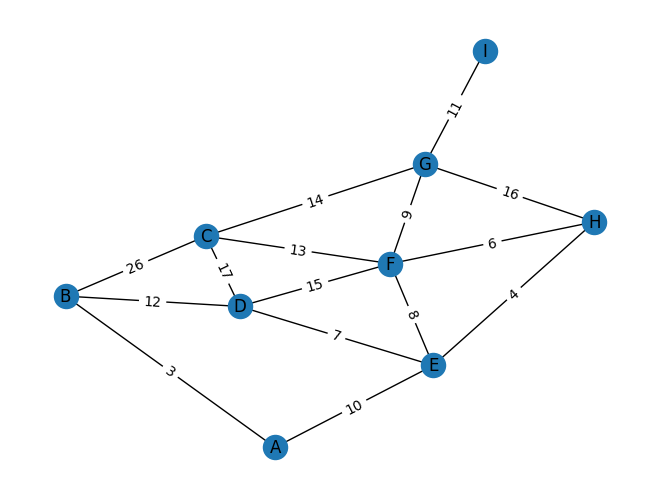

In [7]:
wgraph.draw()  # działa!

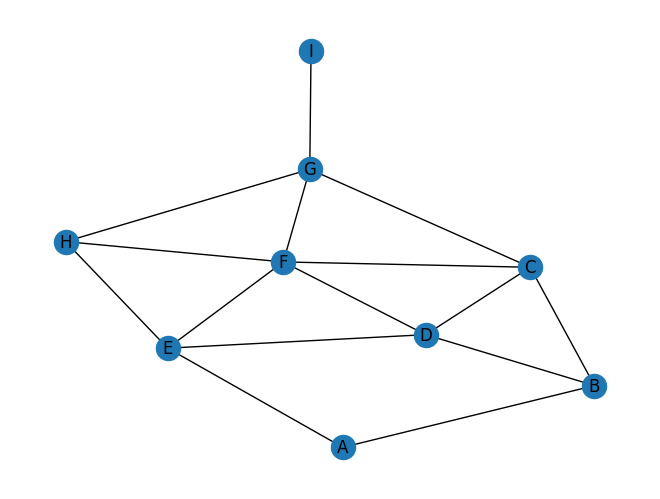

In [8]:
Graph(wgraph.graph).draw() # to stare jest

In [9]:
wtree, total = wgraph.min_spanning_tree()
print(wtree)
print("Total weight:", total)

A: B(3) E(10)
B: A(3)
E: A(10) H(4) D(7)
H: E(4) F(6)
F: H(6) G(9) C(13)
D: E(7)
G: F(9) I(11)
I: G(11)
C: F(13)

Total weight: 63


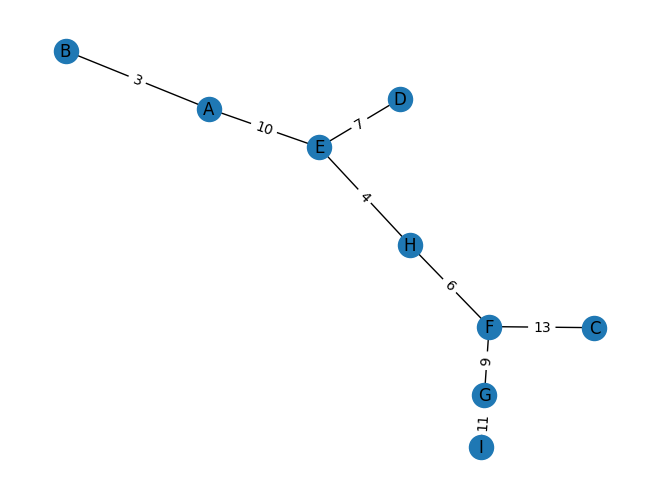

In [10]:
wtree.draw()

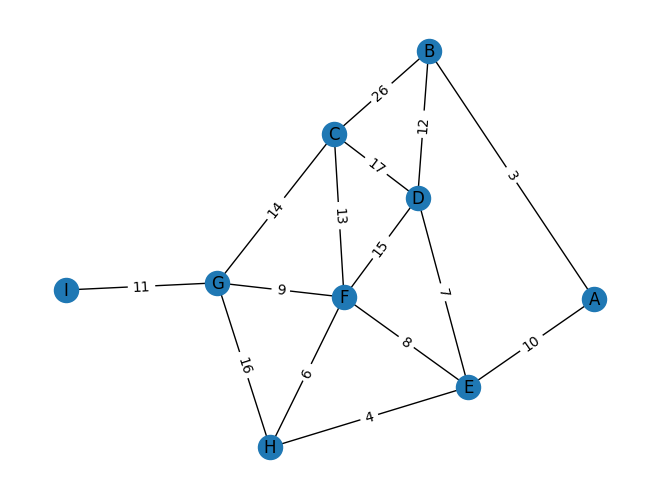

In [12]:
wgraph.draw()

In [11]:
dist, pred = wgraph.Dijkstra("A")
print(dist)
print(pred)

{'A': 0, 'B': 3, 'E': 10, 'C': 29, 'D': 15, 'F': 18, 'G': 27, 'H': 14, 'I': 38}
{'A': None, 'B': 'A', 'E': 'A', 'C': 'B', 'D': 'B', 'F': 'E', 'G': 'F', 'H': 'E', 'I': 'G'}


## Część 4 (przechodzenie grafów).

In [ ]:
graph1 = Graph.random_graph(10, 1/5)
print(graph1)

VT = graph1.connected_components()
print(VT)


1:
2: 8
3: 5
4: 7 8
5: 3 6 10
6: 5
7: 4
8: 2 4
9:
10: 5

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, {1}, {8, 2, 4, 7}, {10, 3, 5, 6}, {9}]


In [ ]:
lista = graph1.connected_components_graphs()
print(lista[0])

1:



In [ ]:
print(lista[1])

8: 2 4
2: 8
4: 7 8
7: 4



In [ ]:
print(lista[1].distance(8))

{8: 0, 2: 1, 4: 1, 7: 2}


## Eksperyment Millgrama (małego świata)
Zbadamy, czy $G(n,p)$ jest dobrym modelem zjawiska.

In [ ]:
n = 2000
p = 1/300
rgraph = Graph.random_graph(n, p)
graph = rgraph.connected_components_graphs()[0]
print(len(graph.vertices()))

1999


In [ ]:
md = {}
ecc = {}
for v in graph.vertices():
  dist = graph.distance(v)
  ecc[v] = max(dist.values())
  md[v] = sum(dist.values()) / len(dist.values())
print("Promień:", min(ecc.values()), " Średnica:", max(ecc.values()), " Average: ", sum(md.values())/len(md))

Promień: 5  Średnica: 7  Average:  4.210159106566796


### Part 3 (Prufer codes)

In [ ]:
%%writefile tree1.txt
1 3
3 5
2 5
4 5
6 5

Writing tree1.txt


In [ ]:
tree1 = Graph.from_edges("tree1.txt")

In [ ]:
print(tree1)

1: 3
3: 1 5
5: 3 2 4 6
2: 5
4: 5
6: 5



In [ ]:
print(tree1.Prufer())

3 5 5 5


In [ ]:
print(Graph.tree_from_Prufer("3 5 5 5"))

1: 3
2: 5
3: 1 5
4: 5
5: 2 3 4 6
6: 5



In [ ]:
print(Graph.tree_from_Prufer("5 4 3 1"))

1: 3 6
2: 5
3: 4 1
4: 5 3
5: 2 4
6: 1



In [ ]:
print(Graph.tree_from_Prufer("1 1 1 2 3"))

1: 4 5 6 2
2: 1 3
3: 2 7
4: 1
5: 1
6: 1
7: 3



### Part2

In [ ]:
%%writefile edges.txt
a b
b c
b d
d
d c
e
f


Overwriting edges.txt


In [ ]:
%cat edges.txt

a b
b c
b d
d
d c
e
f


In [ ]:
graph2 = Graph.from_edges("edges.txt")
print(graph2)

a: b
b: a c d
c: b d
d: b c
e:
f:



In [ ]:
graph2.to_neighbourlist("neighbourhood.txt")

In [ ]:
%cat "neighbourhood.txt"

a: b
b: a c d
c: b d
d: b c
e:
f:


In [ ]:
!wget https://raw.githubusercontent.com/pgordin/OptDisc2025/refs/heads/main/weighted0.txt

--2025-03-31 10:43:59--  https://raw.githubusercontent.com/pgordin/OptDisc2025/refs/heads/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99 [text/plain]
Saving to: ‘weighted0.txt.2’

weighted0.txt.2     100%[===================>]      99  --.-KB/s    in 0s      

2025-03-31 10:43:59 (6.04 MB/s) - ‘weighted0.txt.2’ saved [99/99]



In [ ]:
!wget https://github.com/pgordin/OptDisc2025/raw/main/weighted0.txt

--2025-03-31 10:42:42--  https://github.com/pgordin/OptDisc2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/OptDisc2025/main/weighted0.txt [following]
--2025-03-31 10:42:42--  https://raw.githubusercontent.com/pgordin/OptDisc2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99 [text/plain]
Saving to: ‘weighted0.txt.1’

weighted0.txt.1     100%[===================>]      99  --.-KB/s    in 0s      

2025-03-31 10:42:43 (1.58 MB/s) - ‘weighted0.txt.1’ saved [99/99]



In [ ]:
graph3 = Graph.from_edges("weighted0.txt")
print(graph3)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G



In [ ]:
graph4 = Graph.random_graph(10, 1/3)
print(graph4)

1: 2 4 7 8 9
2: 1 6 8 9
3: 9 10
4: 1 6 7 10
5: 7
6: 2 4 7 9
7: 1 4 5 6 8 10
8: 1 2 7
9: 1 2 3 6
10: 3 4 7



In [ ]:
print(Graph.cycle(6))

1: 2 6
2: 1 3
3: 2 4
4: 3 5
5: 4 6
6: 5 1



### Part1

In [ ]:
vertices = ["a", "b", "c", "d"]
matrix = np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,0,1]])
print(vertices)
print(matrix)
print("---------------------------")
print_matrix(vertices, matrix)
print("---------------------------")
print_matrix(None,matrix)

['a', 'b', 'c', 'd']
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]]
---------------------------
a :  b
b :  a  c
c :  b  d
d :  d
---------------------------
1 :  2
2 :  1  3
3 :  2  4
4 :  4


In [ ]:
graph_dict = {
  "a": ["b"],
  "b": ["a", "c"],
  "c": ["b", "d"],
  "d": ["c"]
}
print(graph_dict)
print("---------------------------")
print_dict(graph_dict)

{'a': ['b'], 'b': ['a', 'c'], 'c': ['b', 'd'], 'd': ['c']}
---------------------------
a :  b
b :  a  c
c :  b  d
d :  c


In [ ]:
graph1 = Graph.from_matrix(matrix, vertices)
print(graph1)

a: b
b: a c
c: b d
d: d



In [ ]:
print(Graph(graph_dict))  # the same result

a: b
b: a c
c: b d
d: c



In [ ]:
print(graph1.vertices())

['a', 'b', 'c', 'd']


In [ ]:
print(graph1.matrix())

[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]]


In [ ]:
graph1.add_vertex("e")
print(graph1)

a: b
b: a c
c: b d
d: d
e:



In [ ]:
graph1.add_edge(["e", "f"])
print(graph1)

a: b
b: a c
c: b d
d: d
e: f
f: e



In [ ]:
graph1.add_arc(["e", "a"])  # breaking the symmetry
print(graph1)

a: b
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.add_edge(["e", "a"])  # restoring the symmetry
print(graph1)

a: b e
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.add_edge(["e", "f"]) # do nothing, an edge already exists
print(graph1)

a: b e
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.del_vertex("f")  # removing a vertex
print(graph1)

a: b e
b: a c
c: b d
d: d
e: a



In [ ]:
graph1.add_edge(["e", "e"]) # an error

ValueError: Loops are not allowed!

In [ ]:
graph1.add_arc(["e", "e"]) # OK - loops are allowed in digraphs
print(graph1)

a: b e
b: a c
c: b d
d: d
e: a e



In [ ]:
print(Graph.cycle(6))

1: 2 6
2: 1 3
3: 2 4
4: 3 5
5: 4 6
6: 5 1

